# Analyze change in glacier velocity after spinup

Brandon S. Tober<br>

02JUL2025<br>

In [1]:
### imports ###
import logging

import matplotlib.cm as cmx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from oggm import cfg, tasks, utils, workflow
from oggm.core import flowline
from oggm.core.flowline import SemiImplicitModel

import pygem.pygem_modelsetup as modelsetup
from pygem import class_climate
from pygem.massbalance import PyGEMMassBalance, PyGEMMassBalance_wrapper
from pygem.oggm_compat import update_cfg
from pygem.shop import debris

logging.getLogger('PIL.PngImagePlugin').setLevel(logging.WARNING)

# pygem imports
import pygem.setup.config as config

# check for config
config.ensure_config()
# read the config
pygem_prms = config.read_config()

# set some plotting defaults
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8
# plt.rcParams["text.usetex"] = True

cfg.initialize(logging_level='CRITICAL')
cfg.PATHS['working_dir'] = (
    f'{pygem_prms["root"]}/{pygem_prms["oggm"]["oggm_gdir_relpath"]}'
)


def get_colors_from_cmap(cmap_name, N):
    cmap = plt.get_cmap(cmap_name)
    return [cmap(i / (N - 1)) for i in range(N)]

# SETUP

In [2]:
# OGGM configuration settings
# update_cfg({"baseline_climate" : "ERA5"}, "PARAMS")
update_cfg({'continue_on_error': True}, 'PARAMS')
update_cfg({'use_multiprocessing': True}, 'PARAMS')
update_cfg({'has_internet': True}, 'PARAMS')

In [3]:
# Glacier Directory initialization for RGIId's of interest. Note, for inversion, we likely want all glaciers
# in a given region, but for testing maybe just a handful

# main_glac_rgi = modelsetup.selectglaciersrgitable(rgi_regionsO1=[1]).iloc[[0,-1]]     # a subset for testing purposes
main_glac_rgi = modelsetup.selectglaciersrgitable(rgi_regionsO1=[1])
main_glac_rgi = main_glac_rgi[main_glac_rgi.RGIId == 'RGI60-01.15645']
rgi_ids = main_glac_rgi['RGIId'].tolist()
gdirs = workflow.init_glacier_directories(rgi_ids)
gdir = gdirs[0]

This study is focusing on 27108 glaciers in region [1]


In [4]:
# PyGEM setup - model datestable, climate data import, prior model parameters

# model dates
dt = modelsetup.datesmodelrun(
    startyear=1940, endyear=2019
)  # will have to cover the time period of inversion (2000-2019) and spinup (1979-~2010 by default). Note, 1940 startyear just in case we want to run spinup starting earlier.
# load climate data
ref_clim = class_climate.GCM(name='ERA5')

# Air temperature [degC]
temp, _ = ref_clim.importGCMvarnearestneighbor_xarray(
    ref_clim.temp_fn, ref_clim.temp_vn, main_glac_rgi, dt
)
# Precipitation [m]
prec, _ = ref_clim.importGCMvarnearestneighbor_xarray(
    ref_clim.prec_fn, ref_clim.prec_vn, main_glac_rgi, dt
)
# Elevation [m asl]
elev = ref_clim.importGCMfxnearestneighbor_xarray(
    ref_clim.elev_fn, ref_clim.elev_vn, main_glac_rgi
)
# Lapse rate [degC m-1]
lr, _ = ref_clim.importGCMvarnearestneighbor_xarray(
    ref_clim.lr_fn, ref_clim.lr_vn, main_glac_rgi, dt
)

# load prior regionally averaged modelprms (from Rounce et al. 2023)
priors_df = pd.read_csv(
    pygem_prms['root'] + '/Output/calibration/' + pygem_prms['calib']['priors_reg_fn']
)

# loop through gdirs and add `glacier_rgi_table`, `historical_climate`, `dates_table` and `modelprms` attributes to each glacier directory
for i, gd in enumerate(gdirs):
    # Select subsets of data
    gd.glacier_rgi_table = main_glac_rgi.loc[main_glac_rgi.index.values[i], :]
    # Add climate data to glacier directory (first inversion data)
    gd.historical_climate = {
        'elev': elev[i],
        'temp': temp[i, :],
        'tempstd': np.zeros(temp[i, :].shape),
        'prec': prec[i, :],
        'lr': lr[i, :],
    }
    gd.dates_table = dt

    # get modelprms from regional priors
    priors_idx = np.where(
        (priors_df.O1Region == gd.glacier_rgi_table['O1Region'])
        & (priors_df.O2Region == gd.glacier_rgi_table['O2Region'])
    )[0][0]
    tbias_mu = float(priors_df.loc[priors_idx, 'tbias_mean'])
    kp_mu = float(priors_df.loc[priors_idx, 'kp_mean'])
    gd.modelprms = {
        'kp': kp_mu,
        'tbias': tbias_mu,
        'ddfsnow': pygem_prms['calib']['MCMC_params']['ddfsnow_mu'],
        'ddfice': pygem_prms['calib']['MCMC_params']['ddfsnow_mu']
        / pygem_prms['sim']['params']['ddfsnow_iceratio'],
        'precgrad': pygem_prms['sim']['params']['precgrad'],
        'tsnow_threshold': pygem_prms['sim']['params']['tsnow_threshold'],
    }

# PREPROCESSING

In [5]:
task_list = [
    tasks.process_climate_data,  # process climate_hisotrical data to gdir
    debris.debris_to_gdir,  # process debris data to gdir
    debris.debris_binned,  # add debris to inversion flowlines
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs)

# SPINUP
For dynamical spinup, we run the dynamical model attempting to find a dynamical state at the specified `spinup_start_yr` which leads to a match to the specified `minimise_for` variable (RGI area by default) at the specified `target_yr`.  As with inversion, we'll use PyGEM's mass balance model for this task (now passed as the `mb_model_historical` variable).  A departure from the way PyGEM's mass balaance model was passed to the inversion task, is that `run_dynamic_spinup` expects `mb_model_historical` to already be instantiated - thus, we cannot run all glaciers simultaneously using something like so:

```{python}
workflow.execute_entity_task(tasks.run_dynamic_spinup,
    gdirs,
    mb_model_historical = partial(PyGEMMassBalance_wrapper, fl_str="model_flowlines")
```

We'll have to instead loop through each gdir, and pass `mb_model_historical` as an instantiated mb model class.  Here, we'll just demonstrate on a single glacier, but will then run all glaciers in parallel in a separate `run_spinup` script.

In [6]:
# get glacier of interest
gd = next((obj for obj in gdirs if obj.rgi_id == 'RGI60-01.15645'), gdirs[0])

In [7]:
# perform OGGM dynamic spinup
tasks.run_dynamic_spinup(
    gd,
    target_yr=2000,  # The year at which we want to match area or volume. If None, gdir.rgi_date + 1 is used (the default)
    minimise_for='area',  # what target to match at the target_yr
    ye=2020,  # When the simulation should stop
    # model_flowline_filesuffix="_pygem_mb",  # The suffix of the model file to start from
    output_filesuffix='_dynamic_spinup_pygem_mb',
    store_fl_diagnostics=True,
    store_model_geometry=True,
    # first_guess_t_spinup = , could be passed as input argument for each step in the sampler based on prior tbias, current default first guess is -2
    mb_model_historical=PyGEMMassBalance_wrapper(
        gd, fl_str='model_flowlines', inversion_filter=True
    ),
)

# load flowline_diagnostics from spinup
f = gd.get_filepath('fl_diagnostics', filesuffix='_dynamic_spinup_pygem_mb')
with xr.open_dataset(f, group='fl_0') as ds_spn:
    # The data is compressed - it's a good idea to store it to memory
    # before playing with it
    ds_spn = ds_spn.load()


# instantiate flowline.FileModel object from model_geometry_dynamic_spinup
fmd_dynamic = flowline.FileModel(
    gd.get_filepath('model_geometry', filesuffix='_dynamic_spinup_pygem_mb')
)
# run FileModel to year 2000 (it will be initialized at `spinup_start_yr`)
# Bring it to year 2000
fmd_dynamic.run_until(2000)
# write flowlines
gd.write_pickle(fmd_dynamic.fls, 'model_flowlines', filesuffix='_2000')
# add debris
debris.debris_binned(gd, fl_str='model_flowlines', filesuffix='_2000')
fls = gd.read_pickle('model_flowlines', filesuffix='_2000')

# QC

Plot various components along glacier flowline (climatic mass balance, dhdt, flux divergence, initial thickness)

Text(0.5, 1.0, 'RGI60-01.15645')

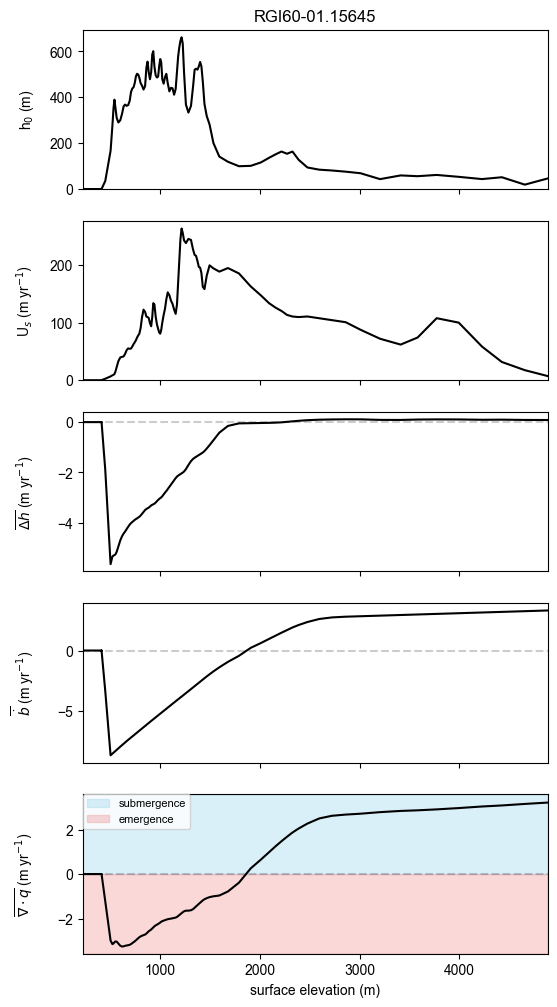

In [8]:
fig, ax = plt.subplots(5, sharex=True, figsize=(6, 12))
surface_h = ds_spn.bed_h.values + ds_spn.sel(time=2000).thickness_m.values
ax[0].plot(surface_h, ds_spn.sel(time=2000).thickness_m, 'k')
ax[1].plot(
    surface_h,
    np.nanmean(ds_spn.sel(time=slice('2000', '2020')).ice_velocity_myr.values, axis=0),
    'k',
)
ax[2].plot(
    surface_h,
    np.nanmean(ds_spn.sel(time=slice('2000', '2020')).dhdt_myr.values, axis=0),
    'k',
)
ax[3].plot(
    surface_h,
    np.nanmean(ds_spn.sel(time=slice('2000', '2020')).climatic_mb_myr.values, axis=0),
    'k',
)
ax[4].plot(
    surface_h,
    -1
    * np.nanmean(
        ds_spn.sel(time=slice('2000', '2020')).flux_divergence_myr.values, axis=0
    ),
    'k',
)

# idx_dh_min = np.nanargmin(delta_h_annual.mean(axis=1))

ax[-1].set_xlabel('surface elevation (m)')
ax[0].set_ylabel(r'h$_{0}$ (m)')
ax[0].set_ylim([0, ax[0].get_ylim()[1]])
ax[1].set_ylim([0, ax[1].get_ylim()[1]])
ax[1].set_ylabel(r'U$_{s}$ (m yr$^{-1}$)')
ax[2].set_ylabel(r'$\overline{\Delta h}$ (m yr$^{-1}$)')
ax[2].axhline(0, color='k', alpha=0.2, ls='--')
ax[3].set_ylabel(r'$\overline{\dot{b}}$ (m yr$^{-1}$)')
ax[3].axhline(0, color='k', alpha=0.2, ls='--')
ax[4].set_ylabel(r'$\overline{\nabla \cdot q}$ (m yr$^{-1}$)')
ax[4].axhline(0, color='k', alpha=0.2, ls='--')
ylims = ax[4].get_ylim()
ax[0].set_xlim([surface_h.min(), surface_h.max()])
ylims = [-np.max(np.abs(ylims)), np.max(np.abs(ylims))]
x = np.arange(ax[4].get_xlim()[0], ax[4].get_xlim()[1], 1)
ax[4].fill_between(x, 0, ylims[1], color='skyblue', alpha=0.3, label='submergence')
ax[4].fill_between(x, 0, ylims[0], color='lightcoral', alpha=0.3, label='emergence')
ax[4].set_ylim(ylims)
ax[4].legend(borderaxespad=0, loc='upper left')

for a in ax:
    a.yaxis.set_label_coords(-0.1, 0.5)
ax[0].set_title(f'{gd.rgi_id}')

Text(0.5, 1.0, 'RGI60-01.15645')

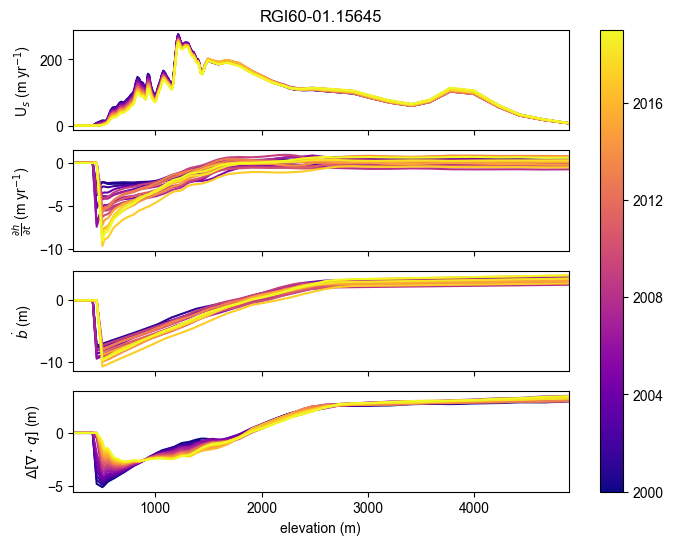

In [9]:
# Get number of years and color map
years = ds_spn.sel(time=slice('2000', '2020')).time.values.astype(int)

# Set up figure and axis
fig, ax = plt.subplots(4, figsize=(8, 6), sharex=True)

# Create colormap and normalization
cmap = plt.get_cmap('plasma')
norm = mcolors.Normalize(vmin=years[0], vmax=years[-1])
scalar_map = cmx.ScalarMappable(norm=norm, cmap=cmap)

# Plot each line with corresponding color
for i, year in enumerate(years):
    ax[0].plot(
        surface_h,
        ds_spn.sel(time=slice('2000', '2020')).ice_velocity_myr.values[i, :],
        c=scalar_map.to_rgba(year),
    )
    ax[1].plot(
        surface_h,
        ds_spn.sel(time=slice('2000', '2020')).dhdt_myr.values[i, :],
        c=scalar_map.to_rgba(year),
    )
    ax[2].plot(
        surface_h,
        ds_spn.sel(time=slice('2000', '2020')).climatic_mb_myr.values[i, :],
        c=scalar_map.to_rgba(year),
    )
    ax[3].plot(
        surface_h,
        -1 * ds_spn.sel(time=slice('2000', '2020')).flux_divergence_myr.values[i, :],
        c=scalar_map.to_rgba(year),
    )

# Add colorbar with integer year ticks
cbar = fig.colorbar(scalar_map, ax=ax)

# Set colorbar ticks to integers, spaced reasonably
tick_step = max(1, len(years) // 5)  # Adjust number of ticks if needed
cbar.set_ticks(years[::tick_step])
cbar.set_ticklabels(years[::tick_step])

# Axis labels
ax[0].set_ylabel(r'U$_{s}$ (m yr$^{-1}$)')
ax[1].set_ylabel(r'$\frac{\partial h}{\partial t}$ (m yr$^{-1}$)')
ax[2].set_ylabel(r'$\dot{b}$ (m)')
ax[3].set_ylabel(r'$\Delta [ \nabla \cdot q ]$ (m)')
ax[3].set_xlabel('elevation (m)')
ax[0].set_xlim([surface_h.min(), surface_h.max()])
ax[0].set_title(f'{gd.rgi_id}')

## NO SPINUP

See how modeled components look when we don't do spinup

In [10]:
tasks.compute_downstream_bedshape(gdir)
tasks.init_present_time_glacier(gdir)  # adds bins below
fls = gdir.read_pickle('model_flowlines')

In [11]:
# instantiate flowline.FileModel object from model_geometry_dynamic_spinup
fmd_dynamic = flowline.FileModel(
    gd.get_filepath('model_geometry', filesuffix='_dynamic_spinup_pygem_mb')
)
# run FileModel to year 2000 (it will be initialized at `spinup_start_yr`)
print(f'Flowline model for {gd.rgi_id} initialized at year {fmd_dynamic.yr}')
# Bring it to year 2000
fmd_dynamic.run_until(2000)
# write flowlines
gd.write_pickle(fmd_dynamic.fls, 'model_flowlines', filesuffix='_2000')
# add debris
debris.debris_binned(gd, fl_str='model_flowlines', filesuffix='_2000');

Flowline model for RGI60-01.15645 initialized at year 1980.0


## NO SPINUP RUN

In [12]:
### RUN DYNAMICS ###
cls = gd.read_pickle('inversion_input')[-1]
th = cls['hgt'][-1]
vmin, vmax = cfg.PARAMS['free_board_marine_terminating']
water_level = utils.clip_scalar(0, th - vmax, th - vmin)
# mass balance model with evolving area
mbmod = PyGEMMassBalance(
    gd,
    gd.modelprms,
    gd.glacier_rgi_table,
    fls=gd.read_pickle('model_flowlines', filesuffix=''),
    inversion_filter=True,
)
glen_a = gd.get_diagnostics()['inversion_glen_a']
fs = gd.get_diagnostics()['inversion_fs']

# glacier dynamics model
ev_model = SemiImplicitModel(
    gd.read_pickle('model_flowlines', filesuffix=''),
    y0=2000,
    mb_model=mbmod,
    glen_a=glen_a,
    fs=fs,
    is_tidewater=gd.is_tidewater,
    water_level=water_level,
)

# run glacier dynamics model forward
_, ds_ns = ev_model.run_until_and_store(2020, fl_diag_path=True)
ds_ns = ds_ns[0]
ds_ns

<xarray.Dataset> Size: 337kB
Dimensions:              (dis_along_flowline: 218, time: 21)
Coordinates:
  * dis_along_flowline   (dis_along_flowline) float64 2kB 0.0 400.0 ... 8.68e+04
  * time                 (time) float64 168B 2e+03 2.001e+03 ... 2.02e+03
Data variables: (12/13)
    point_lons           (dis_along_flowline) float64 2kB -143.7 ... -142.0
    point_lats           (dis_along_flowline) float64 2kB 61.89 61.89 ... 61.89
    bed_h                (dis_along_flowline) float64 2kB 4.841e+03 ... 220.0
    volume_m3            (time, dis_along_flowline) float64 37kB 4.584e+06 .....
    volume_bsl_m3        (time, dis_along_flowline) float64 37kB 0.0 0.0 ... 0.0
    volume_bwl_m3        (time, dis_along_flowline) float64 37kB 3.428e+09 .....
    ...                   ...
    thickness_m          (time, dis_along_flowline) float64 37kB 49.71 ... 0.0
    ice_velocity_myr     (time, dis_along_flowline) float64 37kB nan nan ... 0.0
    calving_bucket_m3    (time) float64 168B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    flux_divergence_myr  (time, dis_along_flowline) float64 37kB nan nan ... 0.0
    climatic_mb_myr      (time, dis_along_flowline) float64 37kB nan nan ... 0.0
    dhdt_myr             (time, dis_along_flowline) float64 37kB nan nan ... 0.0
Attributes: (12/21)
    class:                      MixedBedFlowline
    map_dx:                     200.0
    dx:                         2.0
    description:                OGGM model output
    oggm_version:               1.6.2
    calendar:                   365-day no leap
    ...                         ...
    mb_model_is_tidewater:      0
    mb_model_glacier_gcm_elev:  1259.0935527023714
    mb_model_nmonths:           960
    mb_model_nyears:            80
    mb_model_firnline_idx:      0
    mb_model_sea_level:         0

# SPINUP RUN

In [13]:
# load flowline_diagnostics from spinup
f = gd.get_filepath('fl_diagnostics', filesuffix='_dynamic_spinup_pygem_mb')
with xr.open_dataset(f, group='fl_0') as ds_spn:
    # The data is compressed - it's a good idea to store it to memory
    # before playing with it
    ds_spn = ds_spn.load()

In [14]:
ds_spn

<xarray.Dataset> Size: 651kB
Dimensions:              (dis_along_flowline: 218, time: 41)
Coordinates:
  * dis_along_flowline   (dis_along_flowline) float64 2kB 0.0 400.0 ... 8.68e+04
  * time                 (time) float64 328B 1.98e+03 1.981e+03 ... 2.02e+03
Data variables: (12/13)
    point_lons           (dis_along_flowline) float64 2kB -143.7 ... -142.0
    point_lats           (dis_along_flowline) float64 2kB 61.89 61.89 ... 61.89
    bed_h                (dis_along_flowline) float64 2kB 4.841e+03 ... 220.0
    volume_m3            (time, dis_along_flowline) float64 72kB 4.073e+06 .....
    volume_bsl_m3        (time, dis_along_flowline) float64 72kB 0.0 0.0 ... 0.0
    volume_bwl_m3        (time, dis_along_flowline) float64 72kB 0.0 0.0 ... 0.0
    ...                   ...
    thickness_m          (time, dis_along_flowline) float64 72kB 45.08 ... 0.0
    ice_velocity_myr     (time, dis_along_flowline) float64 72kB nan nan ... 0.0
    calving_bucket_m3    (time) float64 328B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    flux_divergence_myr  (time, dis_along_flowline) float64 72kB nan nan ... 0.0
    climatic_mb_myr      (time, dis_along_flowline) float64 72kB nan nan ... 0.0
    dhdt_myr             (time, dis_along_flowline) float64 72kB nan nan ... 0.0
Attributes: (12/13)
    description:          OGGM model output
    water_level:          0
    dx:                   2.0
    creation_date:        2025-07-02 19:10:36
    fs:                   0
    mb_model_class:       PyGEMMassBalance_wrapper
    ...                   ...
    class:                MixedBedFlowline
    glen_a:               6.0580116695579556e-24
    oggm_version:         1.6.2
    mb_model_rho:         900.0
    mb_model_hemisphere:  nh
    calendar:             365-day no leap

# COMPARISON

Text(0.05, 0.5, 'Flux divergence (m yr$^{-1}$)')

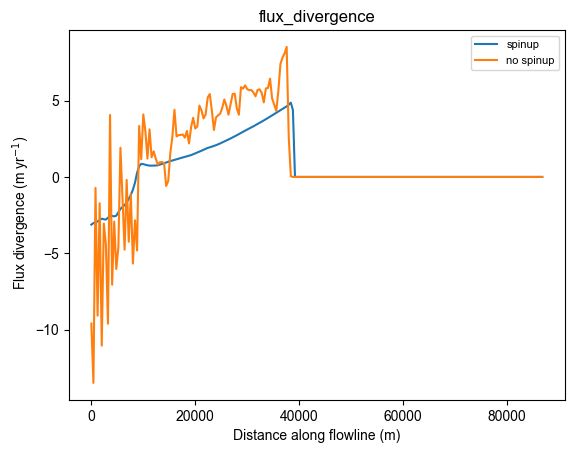

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(
    ds_spn.dis_along_flowline.values,
    ds_spn.sel(time=2001).flux_divergence_myr.values,
    label='spinup',
)
ax.plot(
    ds_ns.dis_along_flowline.values,
    ds_ns.sel(time=2001).flux_divergence_myr.values,
    label='no spinup',
)
ax.legend()
ax.set_title('flux_divergence')
ax.set_xlabel('Distance along flowline (m)')
fig.text(
    0.05, 0.5, 'Flux divergence (m yr$^{-1}$)', rotation=90, ha='center', va='center'
)

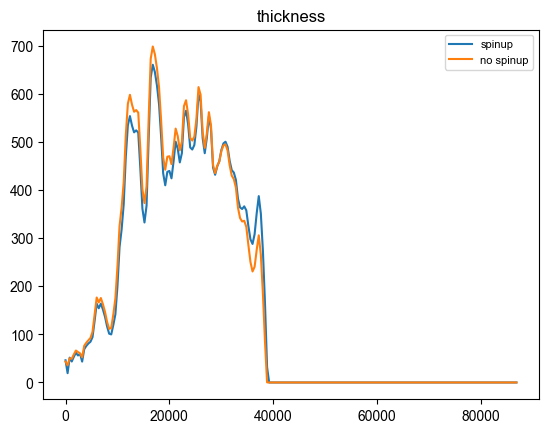

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(ds_spn.dis_along_flowline, ds_spn.sel(time=2001).thickness_m, label='spinup')
ax.plot(ds_ns.dis_along_flowline, ds_ns.sel(time=2001).thickness_m, label='no spinup')
ax.legend()
ax.set_title('thickness');

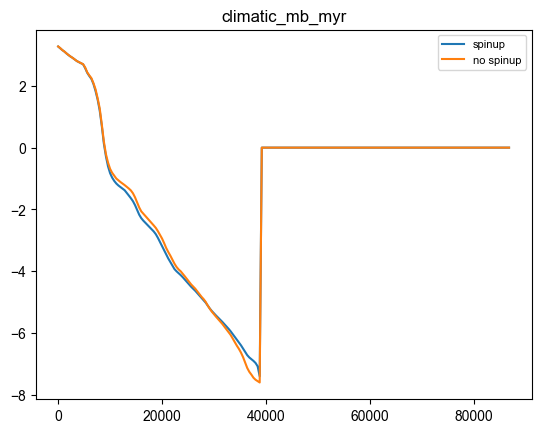

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(
    ds_spn.dis_along_flowline, ds_spn.sel(time=2001).climatic_mb_myr, label='spinup'
)
ax.plot(
    ds_ns.dis_along_flowline, ds_ns.sel(time=2001).climatic_mb_myr, label='no spinup'
)
ax.legend()
ax.set_title('climatic_mb_myr');

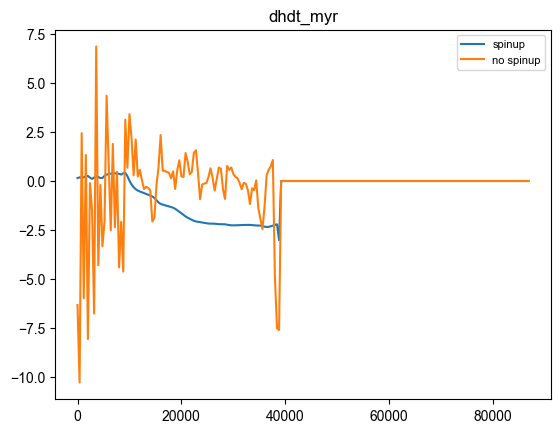

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(ds_spn.dis_along_flowline, ds_spn.sel(time=2001).dhdt_myr, label='spinup')
ax.plot(ds_ns.dis_along_flowline, ds_ns.sel(time=2001).dhdt_myr, label='no spinup')
ax.legend()
ax.set_title('dhdt_myr');

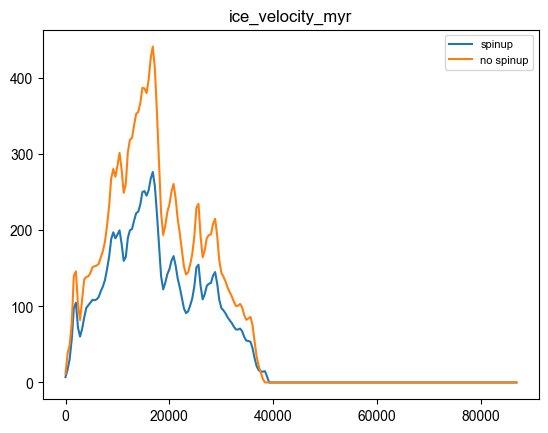

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(
    ds_spn.dis_along_flowline, ds_spn.sel(time=2001).ice_velocity_myr, label='spinup'
)
ax.plot(
    ds_ns.dis_along_flowline, ds_ns.sel(time=2001).ice_velocity_myr, label='no spinup'
)
ax.legend()
ax.set_title('ice_velocity_myr');

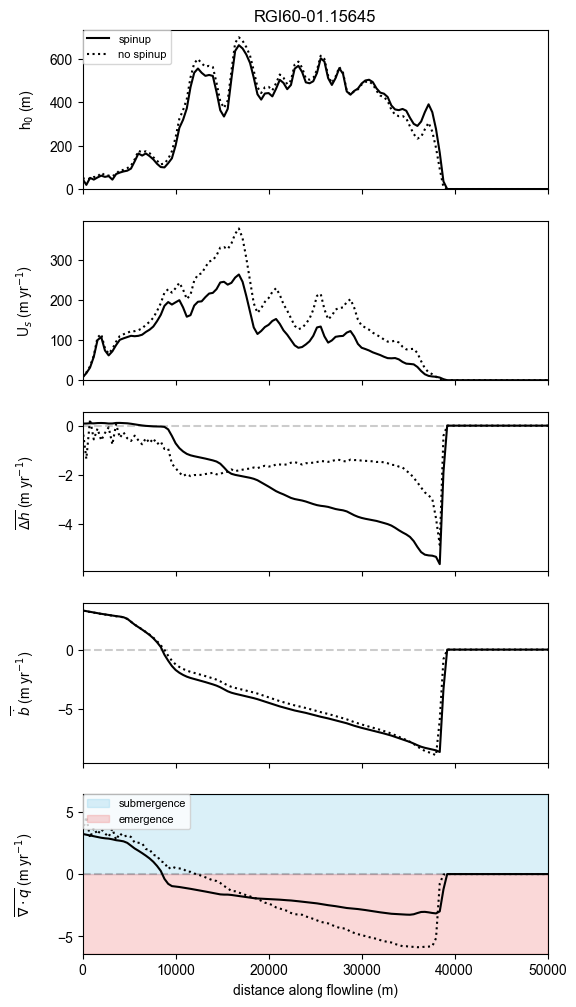

In [27]:
fig, ax = plt.subplots(5, sharex=True, figsize=(6, 12))
surface_h = ds_spn.dis_along_flowline.values
ax[0].plot(surface_h, ds_spn.sel(time=2000).thickness_m, 'k')
ax[0].plot(surface_h, ds_ns.sel(time=2000).thickness_m, 'k:')
ax[1].plot(
    surface_h,
    np.nanmean(ds_spn.sel(time=slice('2000', '2020')).ice_velocity_myr.values, axis=0),
    'k',
)
ax[1].plot(
    surface_h,
    np.nanmean(ds_ns.sel(time=slice('2000', '2020')).ice_velocity_myr.values, axis=0),
    'k:',
)
ax[2].plot(
    surface_h,
    np.nanmean(ds_spn.sel(time=slice('2000', '2020')).dhdt_myr.values, axis=0),
    'k',
)
ax[2].plot(
    surface_h,
    np.nanmean(ds_ns.sel(time=slice('2000', '2020')).dhdt_myr.values, axis=0),
    'k:',
)
ax[3].plot(
    surface_h,
    np.nanmean(ds_spn.sel(time=slice('2000', '2020')).climatic_mb_myr.values, axis=0),
    'k',
)
ax[3].plot(
    surface_h,
    np.nanmean(ds_ns.sel(time=slice('2000', '2020')).climatic_mb_myr.values, axis=0),
    'k:',
)
ax[4].plot(
    surface_h,
    -1
    * np.nanmean(
        ds_spn.sel(time=slice('2000', '2020')).flux_divergence_myr.values, axis=0
    ),
    'k',
)
ax[4].plot(
    surface_h,
    -1
    * np.nanmean(
        ds_ns.sel(time=slice('2000', '2020')).flux_divergence_myr.values, axis=0
    ),
    'k:',
)


ax[-1].set_xlabel('distance along flowline (m)')
ax[0].set_ylabel(r'h$_{0}$ (m)')
ax[0].set_ylim([0, ax[0].get_ylim()[1]])
ax[1].set_ylim([0, ax[1].get_ylim()[1]])
ax[1].set_ylabel(r'U$_{s}$ (m yr$^{-1}$)')
ax[2].set_ylabel(r'$\overline{\Delta h}$ (m yr$^{-1}$)')
ax[2].axhline(0, color='k', alpha=0.2, ls='--')
ax[3].set_ylabel(r'$\overline{\dot{b}}$ (m yr$^{-1}$)')
ax[3].axhline(0, color='k', alpha=0.2, ls='--')
ax[4].set_ylabel(r'$\overline{\nabla \cdot q}$ (m yr$^{-1}$)')
ax[4].axhline(0, color='k', alpha=0.2, ls='--')
ylims = ax[4].get_ylim()
ax[0].set_xlim([surface_h.min(), 50000])
ylims = [-np.max(np.abs(ylims)), np.max(np.abs(ylims))]
ax[0].plot([], [], 'k', label='spinup')
ax[0].plot([], [], 'k:', label='no spinup')
ax[0].legend(borderaxespad=0, loc='upper left')
x = np.arange(ax[4].get_xlim()[0], ax[4].get_xlim()[1], 1)
ax[4].fill_between(x, 0, ylims[1], color='skyblue', alpha=0.3, label='submergence')
ax[4].fill_between(x, 0, ylims[0], color='lightcoral', alpha=0.3, label='emergence')
ax[4].set_ylim(ylims)
ax[4].legend(borderaxespad=0, loc='upper left')

for a in ax:
    a.yaxis.set_label_coords(-0.1, 0.5)
ax[0].set_title(f'{gd.rgi_id}')
fig.savefig(
    '/Users/btober/Documents/tmp/kennicott_spinup_vs_no_spinup.png',
    dpi=300,
    bbox_inches='tight',
)

Text(0, 0.5, '$\\Delta U_{s}$ (m yr$^{-1}$)')

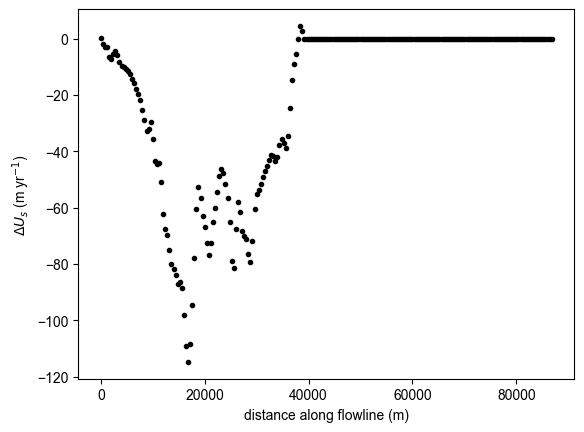

In [31]:
plt.plot(
    surface_h,
    np.nanmean(ds_spn.sel(time=slice('2000', '2020')).ice_velocity_myr.values, axis=0)
    - np.nanmean(ds_ns.sel(time=slice('2000', '2020')).ice_velocity_myr.values, axis=0),
    'k.',
)
# ax[1].plot(surface_h, np.nanmean(ds_ns.sel(time=slice('2000', '2020')).ice_velocity_myr.values,axis=0), 'k:')
plt.xlabel('distance along flowline (m)')
plt.ylabel(r'$\Delta U_{s}$ (m yr$^{-1}$)')

We now have a workflow to run bed inversion and dynamical spinup using PyGEM's mass balance model.  Taking this workfow, can run dynamical spinup over glaciers of interest in parallel using a separate script `run_spinup.py`:

E.g.
```{python}
run_spinup -rgi_glac_number 1.00570 -target_yr 2000
```

or for an entire region:
```{bash}
run_spinup -rgi_region01 1 -target_yr 2000
```